We analyze the time evolution of MNP distribution in the gels with different MNP sizes. We classify MNPs based on their location (inside, surface, outside) using an ellipsoid model. We calculate and plot the Radial Number Density. The results visualize the spatial classification and density profiles, highlighting how MNPs redistribute over time, specifically showing the radius of maximum density.

In [185]:
import sys

sys.path.append("../")

In [186]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

import common
import analysis.distribution
import analysis.magnetic

In [ ]:
base_dir = Path("../../data/raw/10012025_mnp_insertion_of_different_sizes")
if not base_dir.exists():
    raise
gel_dirs = [common.GelDir(p) for p in base_dir.iterdir()]
print(len(gel_dirs))

4


In [188]:
records = []
for gel_dir in gel_dirs:
    for p in gel_dir.mmgel_eq_path.glob("MNPPos*.npy"):
        records.append({"path": p, "timestep": int(p.stem.split("_")[-1]), "type": "MNP", "gel_dir_path": gel_dir.path})
    for p in gel_dir.mmgel_eq_path.glob("BeadPos*.npy"):
        records.append(
            {"path": p, "timestep": int(p.stem.split("_")[-1]), "type": "Bead", "gel_dir_path": gel_dir.path}
        )
path_df = pd.DataFrame.from_records(records).sort_values(by="timestep", ignore_index=True)
path_df

,path,timestep,type,gel_dir_path
0,../../data/raw/10012025_mnp_insertion_of_diffe...,1500,MNP,../../data/raw/10012025_mnp_insertion_of_diffe...
1,../../data/raw/10012025_mnp_insertion_of_diffe...,1500,Bead,../../data/raw/10012025_mnp_insertion_of_diffe...
2,../../data/raw/10012025_mnp_insertion_of_diffe...,1500,MNP,../../data/raw/10012025_mnp_insertion_of_diffe...
3,../../data/raw/10012025_mnp_insertion_of_diffe...,1500,MNP,../../data/raw/10012025_mnp_insertion_of_diffe...
4,../../data/raw/10012025_mnp_insertion_of_diffe...,1500,Bead,../../data/raw/10012025_mnp_insertion_of_diffe...
...,...,...,...,...
6115,../../data/raw/10012025_mnp_insertion_of_diffe...,1483500,Bead,../../data/raw/10012025_mnp_insertion_of_diffe...
6116,../../data/raw/10012025_mnp_insertion_of_diffe...,1485000,MNP,../../data/raw/10012025_mnp_insertion_of_diffe...
6117,../../data/raw/10012025_mnp_insertion_of_diffe...,1485000,Bead,../../data/raw/10012025_mnp_insertion_of_diffe...
6118,../../data/raw/10012025_mnp_insertion_of_diffe...,1486500,MNP,../../data/raw/10012025_mnp_insertion_of_diffe...


run=0_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.2_diameter=10.0
outside    138
surface      0
inside       0
dtype: int64

run=0_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.2_diameter=10.0
outside    133
surface      5
inside       0
dtype: int64

run=0_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.2_diameter=10.0
outside    131
surface      7
inside       0
dtype: int64

run=0_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.2_diameter=10.0
outside    131
surface      7
inside       0
dtype: int64

run=0_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.2_diameter=10.0
outside    131
surface      7
inside       0
dtype: int64

run=0_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.2_diameter=5.0
outside    1121
surface      33
inside        2
dtype: int64

run=0_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.2_diameter=5.0
outside    1124
surface      26
inside        6
dtype: int64

run=0_ff=harmonic_charge=0.05_vf=0.45_crosslink=0.2_diameter=5.0
outside    1126
surface      25
inside        5
dtype: i

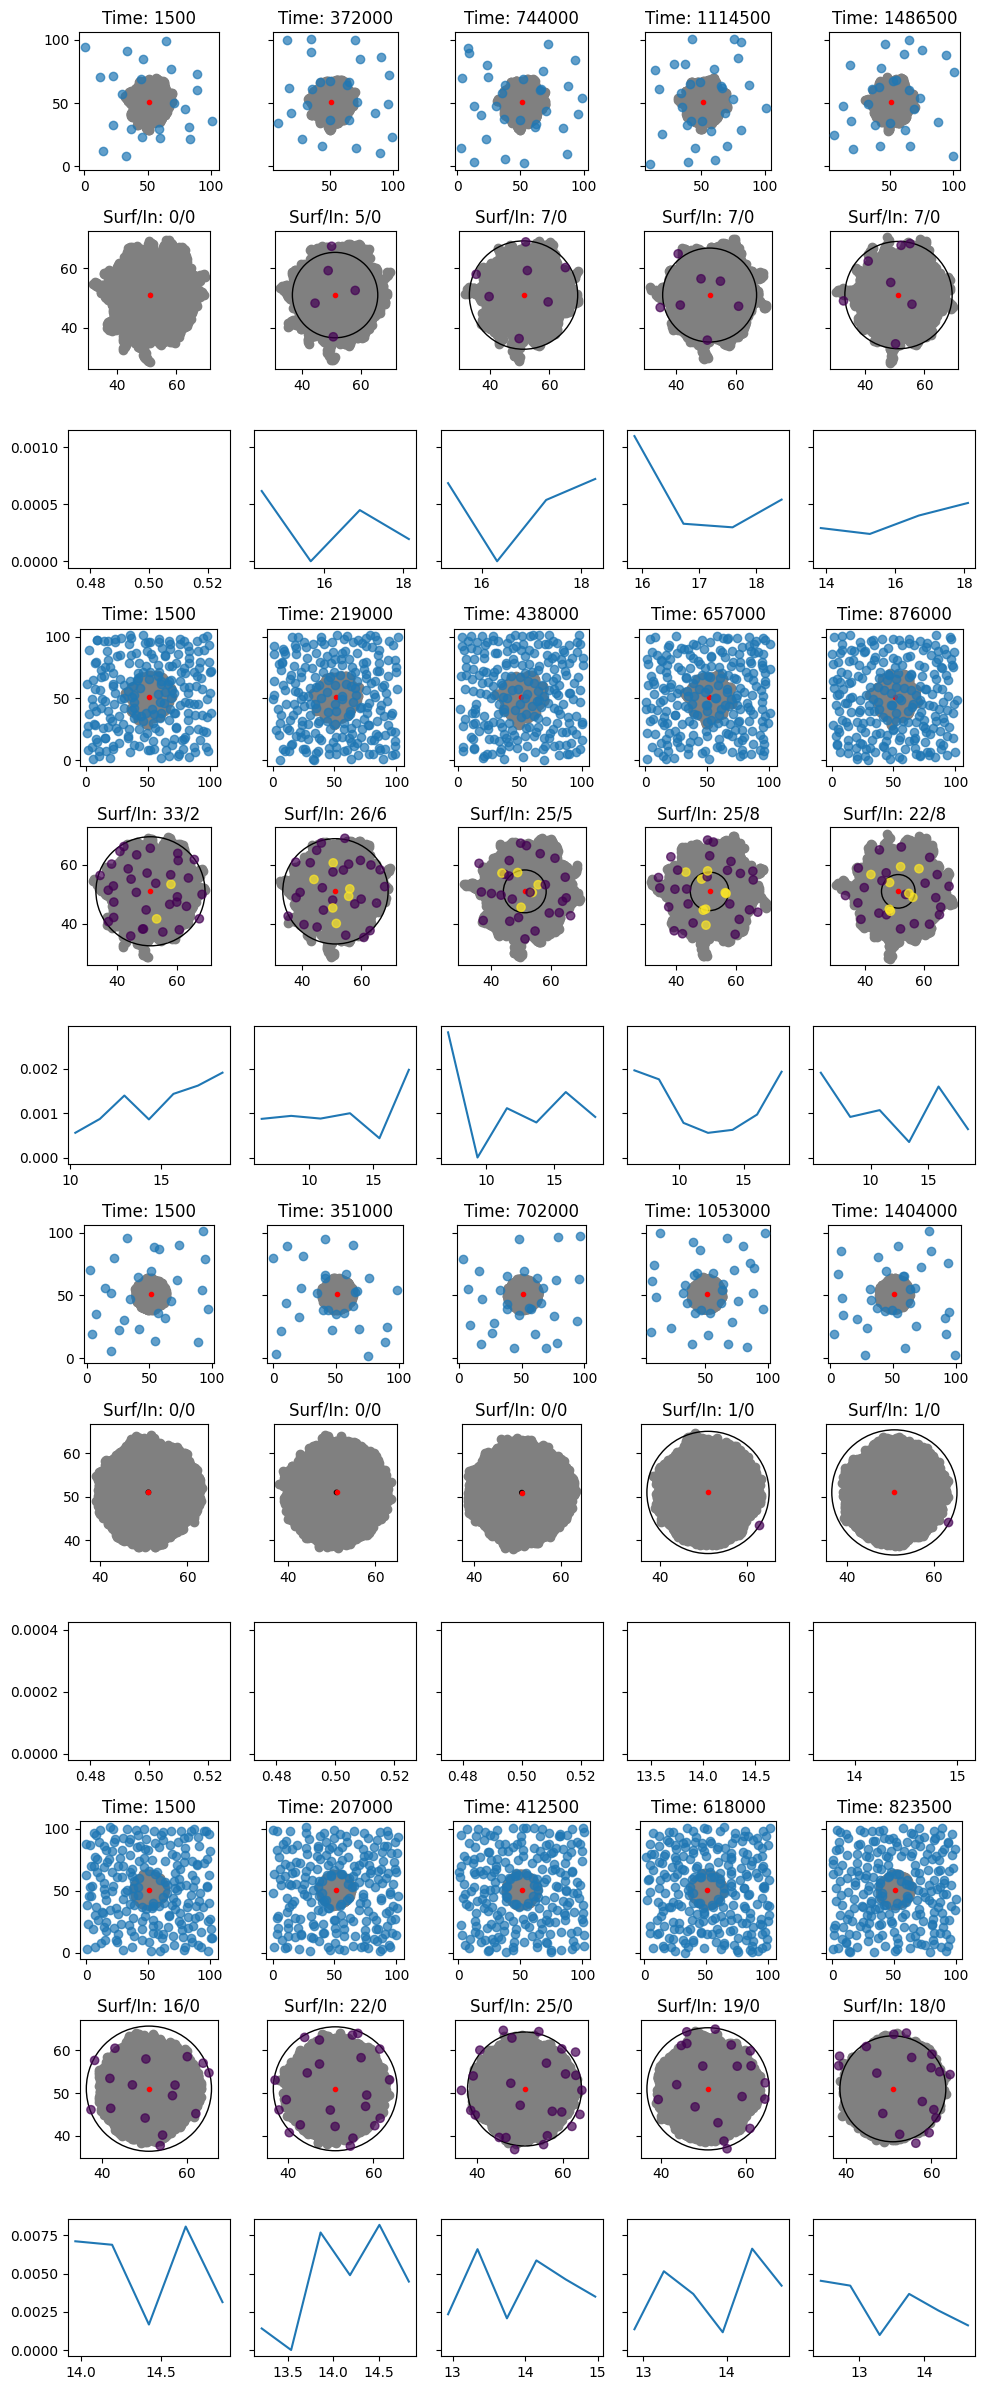

In [189]:
ncols = 5
nrows = 3 * len(path_df["gel_dir_path"].unique())

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2), sharex=False, sharey="row")

for row, (group, tmp_df) in enumerate(path_df.groupby("gel_dir_path")):
    sub_df = tmp_df[tmp_df["type"] == "MNP"]
    sub_df_beads = tmp_df[tmp_df["type"] == "Bead"]
    timestep_indices = np.linspace(0, len(sub_df["timestep"]) - 1, ncols, endpoint=True, dtype=int)
    sub_df = sub_df.iloc[timestep_indices]
    assert len(sub_df) == ncols, len(sub_df)

    gel_dir = common.GelDir(group)
    BOX_L = gel_dir.config.final_box_l

    for col in range(ncols):
        mnp_points = np.load(sub_df.iloc[col]["path"])
        mnp_points = np.mod(mnp_points, BOX_L)
        bead_points = np.load(sub_df_beads.iloc[col]["path"])
        bead_com = bead_points.mean(axis=0)

        mnp_classifier = analysis.magnetic.NanoparticleClassifier(bead_positions=bead_points, np_positions=mnp_points)
        mnp_classes, _ = mnp_classifier.classify("ellipsoid")

        print(gel_dir.path.name)
        print(mnp_classes.value_counts())
        print()

        axs[3 * row, col].set_aspect("equal")
        axs[3 * row + 1, col].set_aspect("equal")
        axs[3 * row, col].set_title(f"Time: {sub_df.iloc[col]['timestep']}")

        # mnps sliced
        ax = axs[3 * row, col]
        mnp_points_slice = mnp_points[np.abs(mnp_points[:, -1] - BOX_L / 2) < 10]
        ax.scatter(*mnp_points_slice[:, :2].T, alpha=0.7, zorder=100)
        ax.scatter(*bead_points[:, :2].T, zorder=-10, color="grey")
        ax.plot(*bead_com[:2], "r.")

        # non-outside mnps
        ax = axs[3 * row + 1, col]
        mask = mnp_classes != "outside"
        ax.set_title(f"Surf/In: {np.count_nonzero(mnp_classes == 'surface')}/{np.count_nonzero(mnp_classes == 'inside')}")
        ax.scatter(*mnp_points[mask, :2].T, alpha=0.7, c=mnp_classes[mask].cat.codes, zorder=100)
        ax.scatter(*bead_points[:, :2].T, zorder=-10, color="grey")
        ax.plot(*bead_com[:2], "r.")

        # radial number density
        ax2 = axs[3 * row + 2, col]
        rnd_result = analysis.distribution.compute_radial_number_density(
            mnp_points[mask], bead_com, #range=(0, np.max(np.linalg.norm(mnp_points[mask] - bead_com)))
        )
        ax2.plot(rnd_result.r, rnd_result.number_density)

        # max density radius
        circle = patches.Circle(
            bead_com[:2], rnd_result.r[np.argmax(rnd_result.number_density)], fill=False, edgecolor="k", linewidth=1
        )
        ax.add_patch(circle)

plt.tight_layout()
plt.show()